In [1]:
import sys
import os
import time
import shutil
import re
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import transforms as T

from hyperparameters import *
from data_manager import rgbd_gradients_dataset, rgbd_gradients_dataloader
from functions import torch2np_u8
import plot
from plot import post_epoch_plot
from models import SpecialFuseNetModel
from data_manager import rgbd_gradients_dataset, rgbd_gradients_dataloader
from train import FuseNetTrainer

np.set_printoptions(threshold=sys.maxsize)
# %matplotlib notebook

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [3]:
CWD             = os.getcwd()
DATASET_DIR     = os.path.join(CWD,'data/nyuv2_overfit')
print(DATASET_DIR)

/home/manor/cs236781-DeepLearning/project/master/data/nyuv2_overfit


In [4]:
dl_train, dl_test = rgbd_gradients_dataloader(root=DATASET_DIR,use_transforms=True, overfit_mode=True)

In [5]:
train_sample_batch = next(iter(dl_train))
print('rgb: <shape>=', train_sample_batch['rgb'].shape, 
      ' <min>=',       train_sample_batch['rgb'].min(),
      ' <max>=',       train_sample_batch['rgb'].max(),
      ' <mean>=',      train_sample_batch['rgb'].mean(), 
      ' <std>=',       train_sample_batch['rgb'].std())
print('depth: <shape>=', train_sample_batch['depth'].shape,
      ' <min>=',         train_sample_batch['depth'].min(),
      ' <max>=',         train_sample_batch['depth'].max(),
      ' <mean>=',        train_sample_batch['depth'].mean(),
      ' <std>=',         train_sample_batch['depth'].std())
print('x: <shape>=', train_sample_batch['x'].shape, 
      ' <min>=',     train_sample_batch['x'].min(),
      ' <max>=',     train_sample_batch['x'].max(),
      ' <mean>=',    train_sample_batch['x'].mean(),
      ' <std>=',     train_sample_batch['x'].std())
print('y: <shape>=', train_sample_batch['y'].shape, 
      ' <min>=',     train_sample_batch['y'].min(),
      ' <max>=',     train_sample_batch['y'].max(),
      ' <mean>=',    train_sample_batch['y'].mean(),
      ' <std>=',     train_sample_batch['y'].std())

rgb: <shape>= torch.Size([1, 3, 224, 224])  <min>= tensor(-1.)  <max>= tensor(1.)  <mean>= tensor(-0.1717)  <std>= tensor(0.4608)
depth: <shape>= torch.Size([1, 1, 224, 224])  <min>= tensor(-1.)  <max>= tensor(0.9922)  <mean>= tensor(-0.5230)  <std>= tensor(0.4480)
x: <shape>= torch.Size([1, 1, 224, 224])  <min>= tensor(-1.)  <max>= tensor(1.)  <mean>= tensor(-0.2095)  <std>= tensor(0.1234)
y: <shape>= torch.Size([1, 1, 224, 224])  <min>= tensor(-1.)  <max>= tensor(1.)  <mean>= tensor(0.2947)  <std>= tensor(0.0787)


In [6]:
test_sample_batch = next(iter(dl_test))
print('rgb: <shape>=', test_sample_batch['rgb'].shape, 
      ' <min>=',       test_sample_batch['rgb'].min(),
      ' <max>=',       test_sample_batch['rgb'].max(),
      ' <mean>=',      test_sample_batch['rgb'].mean(), 
      ' <std>=',       test_sample_batch['rgb'].std())
print('depth: <shape>=', test_sample_batch['depth'].shape,
      ' <min>=',         test_sample_batch['depth'].min(),
      ' <max>=',         test_sample_batch['depth'].max(),
      ' <mean>=',        test_sample_batch['depth'].mean(),
      ' <std>=',         test_sample_batch['depth'].std())
print('x: <shape>=', test_sample_batch['x'].shape, 
      ' <min>=',     test_sample_batch['x'].min(),
      ' <max>=',     test_sample_batch['x'].max(),
      ' <mean>=',    test_sample_batch['x'].mean(),
      ' <std>=',     test_sample_batch['x'].std())
print('y: <shape>=', test_sample_batch['y'].shape, 
      ' <min>=',     test_sample_batch['y'].min(),
      ' <max>=',     test_sample_batch['y'].max(),
      ' <mean>=',    test_sample_batch['y'].mean(),
      ' <std>=',     test_sample_batch['y'].std())

rgb: <shape>= torch.Size([1, 3, 224, 224])  <min>= tensor(-1.)  <max>= tensor(1.)  <mean>= tensor(-0.1717)  <std>= tensor(0.4608)
depth: <shape>= torch.Size([1, 1, 224, 224])  <min>= tensor(-1.)  <max>= tensor(0.9922)  <mean>= tensor(-0.5230)  <std>= tensor(0.4480)
x: <shape>= torch.Size([1, 1, 224, 224])  <min>= tensor(-1.)  <max>= tensor(1.)  <mean>= tensor(-0.2095)  <std>= tensor(0.1234)
y: <shape>= torch.Size([1, 1, 224, 224])  <min>= tensor(-1.)  <max>= tensor(1.)  <mean>= tensor(0.2947)  <std>= tensor(0.0787)


In [7]:
rgb_size = tuple(train_sample_batch['rgb'].shape[1:])
depth_size = tuple(train_sample_batch['depth'].shape[1:])
grads_size = tuple(train_sample_batch['x'].shape[1:])

In [8]:
fusenetmodel = SpecialFuseNetModel(rgb_size=rgb_size,depth_size=depth_size,grads_size=grads_size,
                                   device=device, dropout_p=0)

[I] - device=cpu
    - seed=42
    - dropout_p=0
    - optimizer=None
    - scheduler=None
[I] - Init SpecialFuseNet
    - warm start=True
    - BN momentum=0.1
    - dropout_p=0
[I] - Initialize Net.
    - Init type=xavier
    - Init gain=0.02

[I] - default optimizer set: SGD(lr=0.001,momentum=0.9,weight_decay=0.0005)
[I] - default scheduler set: StepSR(step_size=1000,gamma=0.1)


In [9]:
train_sample_batch1 = next(iter(dl_train))
train_sample_batch2 = next(iter(dl_train))
print(f"Consecutive RGB mini-batchs equals: {not np.any((train_sample_batch1['rgb']-train_sample_batch2['rgb']).numpy())}")
print(f"Consecutive D mini-batchs equals: {not np.any((train_sample_batch1['depth']-train_sample_batch2['depth']).numpy())}")
print(f"Consecutive X mini-batchs equals: {not np.any((train_sample_batch1['x']-train_sample_batch2['x']).numpy())}")
print(f"Consecutive Y mini-batchs equals: {not np.any((train_sample_batch1['y']-train_sample_batch2['y']).numpy())}")

Consecutive RGB mini-batchs equals: True
Consecutive D mini-batchs equals: True
Consecutive X mini-batchs equals: True
Consecutive Y mini-batchs equals: True


In [10]:
xy1 = fusenetmodel(train_sample_batch1['rgb'],train_sample_batch1['depth']).detach()
xy2 = fusenetmodel(train_sample_batch2['rgb'],train_sample_batch2['depth']).detach()
print(f"Outputs on consecutive mini-batchs equals: {not np.any((xy1-xy2).numpy())}")

Outputs on consecutive mini-batchs equals: True


In [11]:
checkpoint_file = 'checkpoints/special_fusenet_overfit'
final_checkpoint_file = checkpoint_file + '_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

In [12]:
trainer = FuseNetTrainer(model=fusenetmodel, device=device,num_epochs=50)

--- EPOCH 1/50 ---
test_batch (Avg. Loss 0.068: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


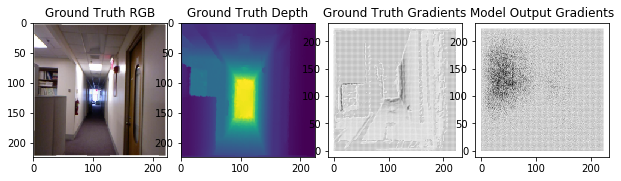

test_batch (Avg. Loss 0.055: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 2
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


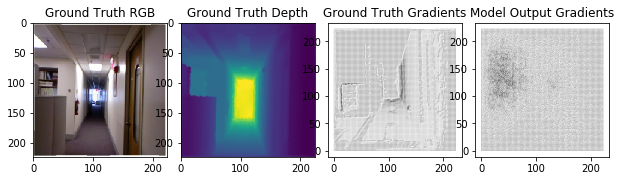

test_batch (Avg. Loss 0.038: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 3
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


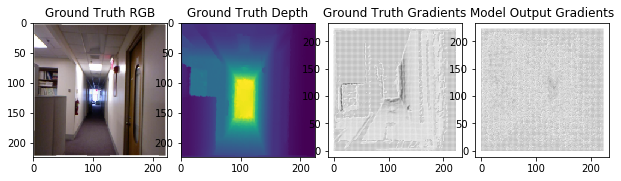

test_batch (Avg. Loss 0.024: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 4
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


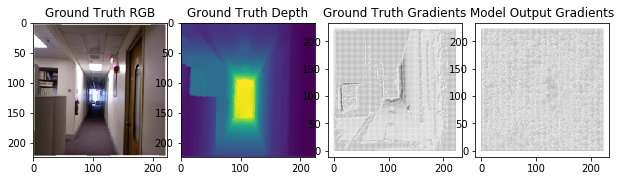

test_batch (Avg. Loss 0.014: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 5
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


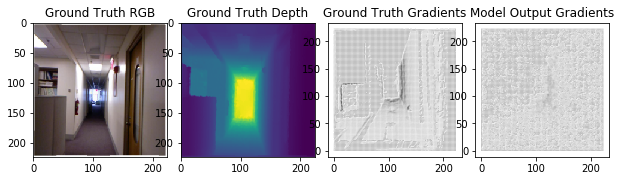

test_batch (Avg. Loss 0.010: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 6
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


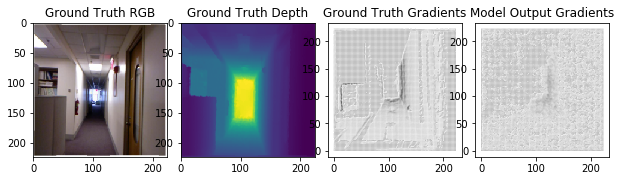

test_batch (Avg. Loss 0.010: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


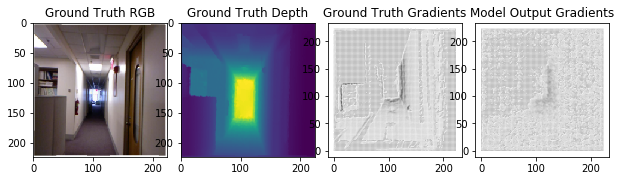

test_batch (Avg. Loss 0.013: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


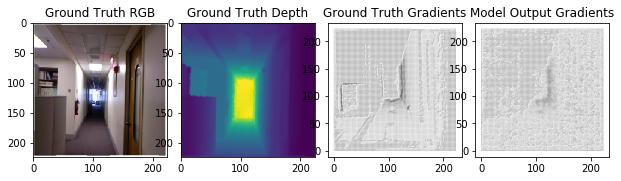

test_batch (Avg. Loss 0.017: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


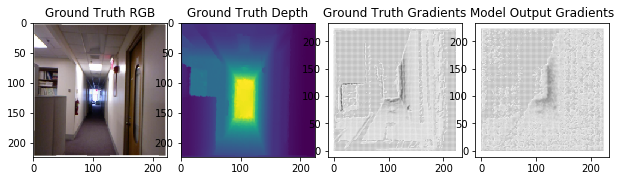

test_batch (Avg. Loss 0.020: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


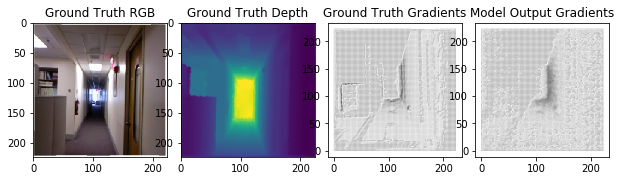

--- EPOCH 11/50 ---
test_batch (Avg. Loss 0.020: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


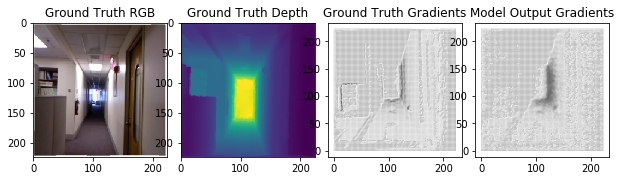

test_batch (Avg. Loss 0.017: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


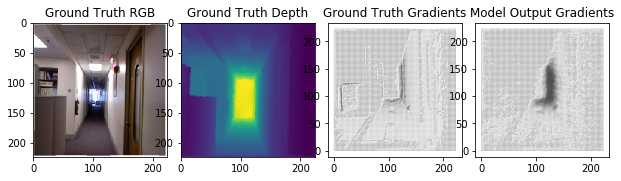

test_batch (Avg. Loss 0.015: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


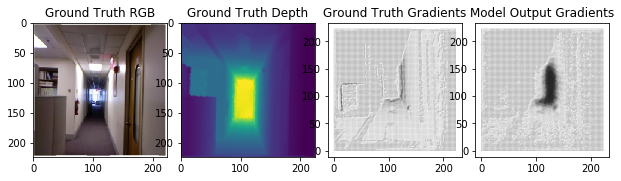

test_batch (Avg. Loss 0.013: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


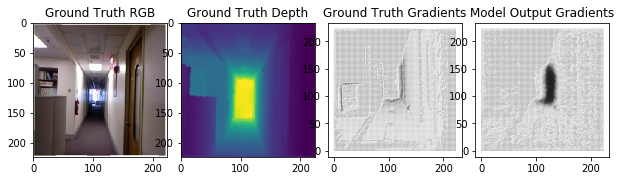

test_batch (Avg. Loss 0.012: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


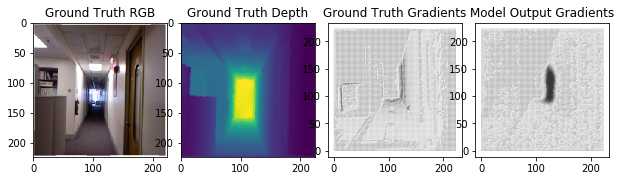

test_batch (Avg. Loss 0.011: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


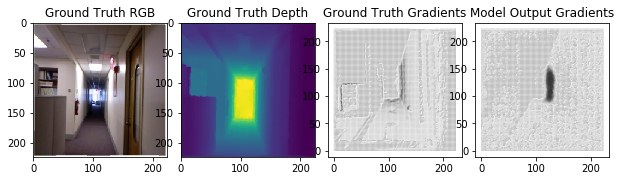

test_batch (Avg. Loss 0.011: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


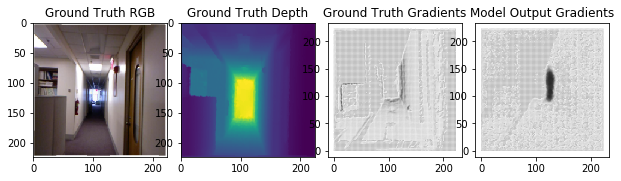

test_batch (Avg. Loss 0.010: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


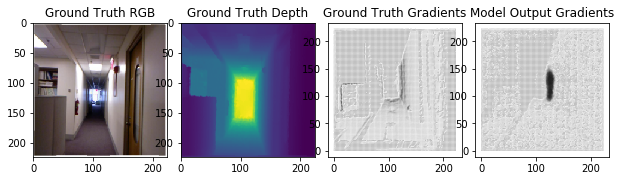

test_batch (Avg. Loss 0.010: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


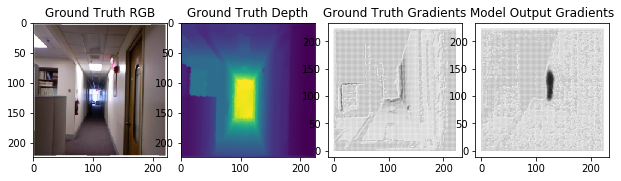

test_batch (Avg. Loss 0.009: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 20
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


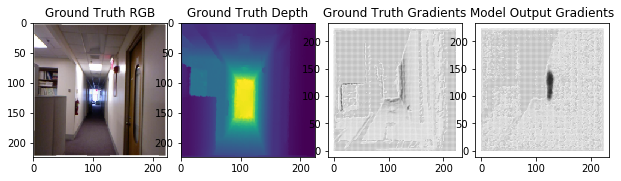

--- EPOCH 21/50 ---
test_batch (Avg. Loss 0.009: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 21
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


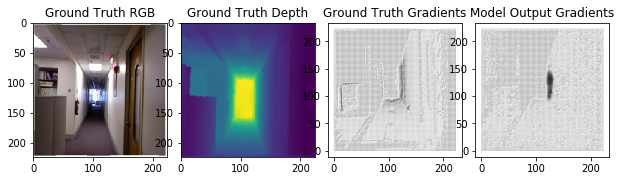

test_batch (Avg. Loss 0.009: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 22
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


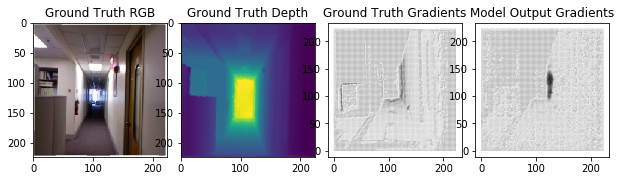

test_batch (Avg. Loss 0.008: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 23
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


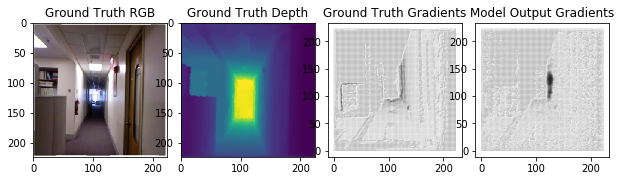

test_batch (Avg. Loss 0.008: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 24
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


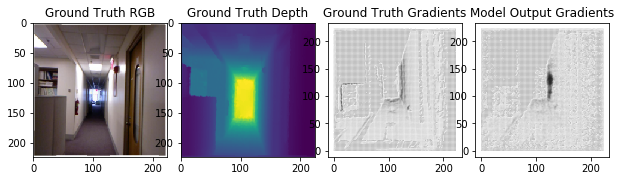

test_batch (Avg. Loss 0.008: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 25
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


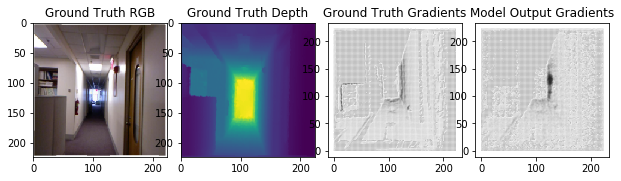

test_batch (Avg. Loss 0.008: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 26
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


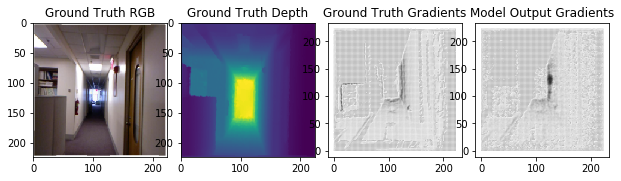

test_batch (Avg. Loss 0.007: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 27
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


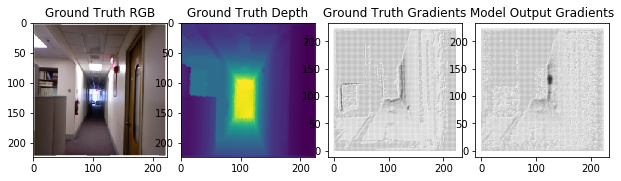

test_batch (Avg. Loss 0.007: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 28
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


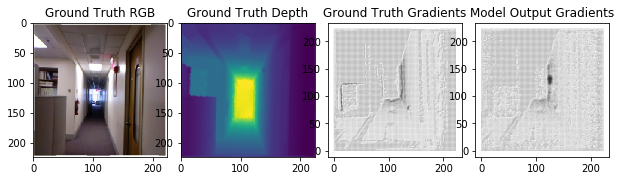

test_batch (Avg. Loss 0.007: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 29
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


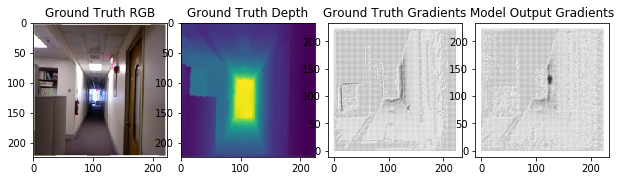

test_batch (Avg. Loss 0.007: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 30
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


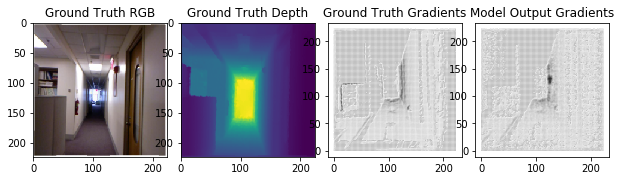

--- EPOCH 31/50 ---
test_batch (Avg. Loss 0.007: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 31
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


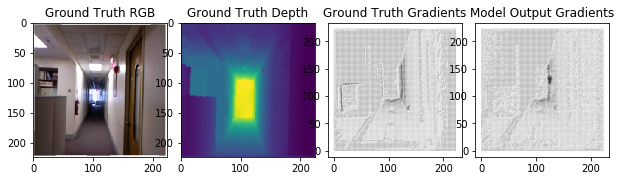

test_batch (Avg. Loss 0.007: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 32
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


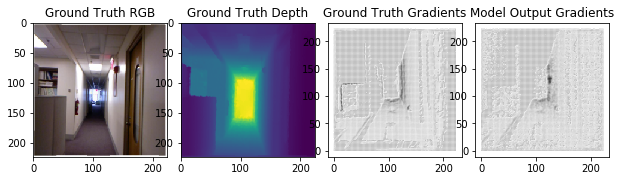

test_batch (Avg. Loss 0.006: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 33
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


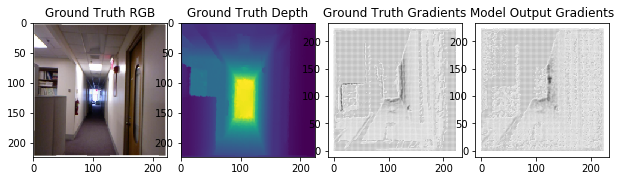

test_batch (Avg. Loss 0.006: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 34
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


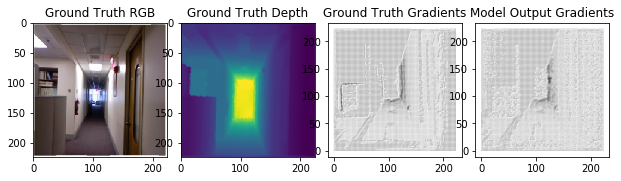

test_batch (Avg. Loss 0.006: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 35
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


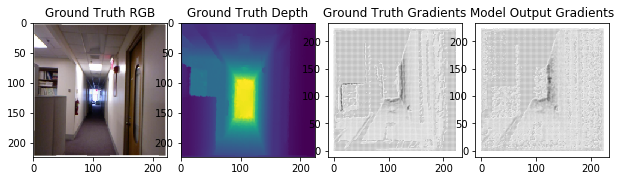

test_batch (Avg. Loss 0.006: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 36
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


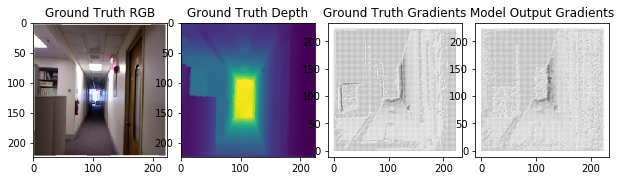

test_batch (Avg. Loss 0.006: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 37
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


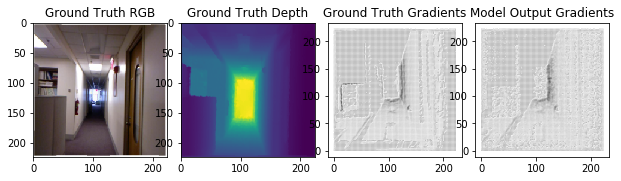

test_batch (Avg. Loss 0.006: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 38
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


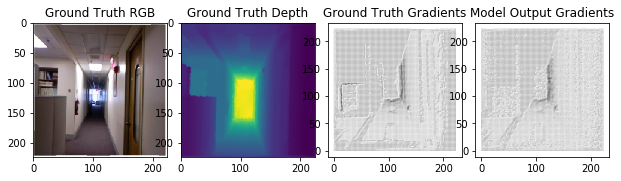

test_batch (Avg. Loss 0.006: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 39
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


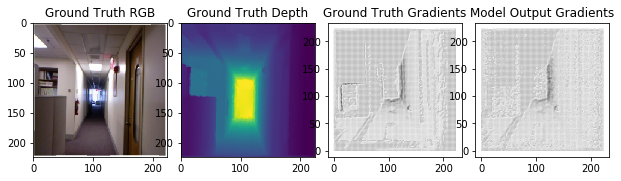

test_batch (Avg. Loss 0.006: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 40
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


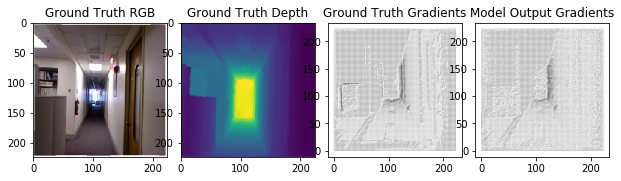

--- EPOCH 41/50 ---
test_batch (Avg. Loss 0.005: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 41
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


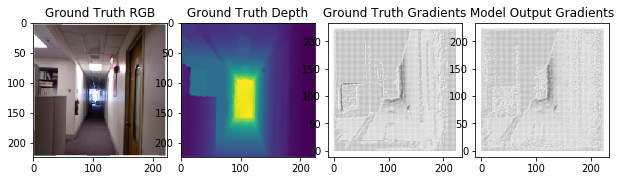

test_batch (Avg. Loss 0.005: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 42
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


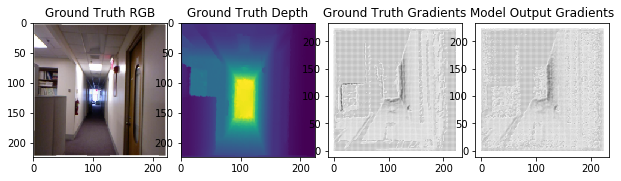

test_batch (Avg. Loss 0.005: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 43
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


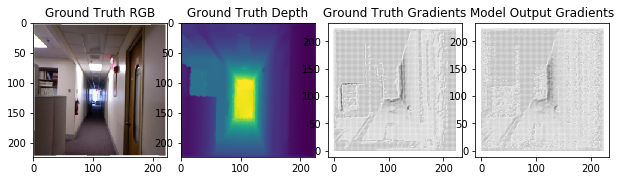

test_batch (Avg. Loss 0.005: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 44
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


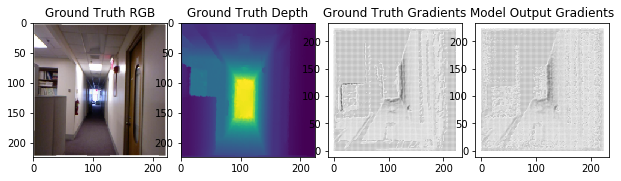

test_batch (Avg. Loss 0.005: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 45
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


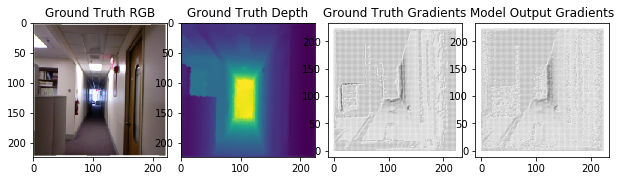

test_batch (Avg. Loss 0.005: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 46
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


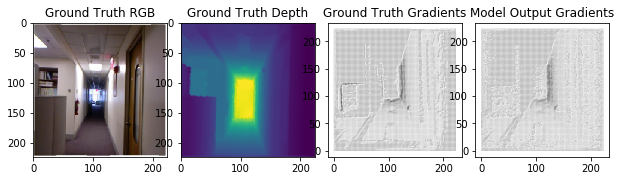

test_batch (Avg. Loss 0.005: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 47
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


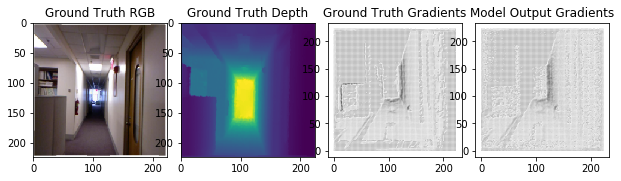

test_batch (Avg. Loss 0.005: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 48
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


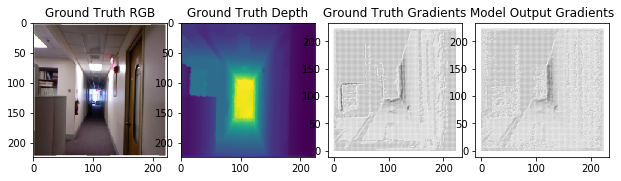

test_batch (Avg. Loss 0.005: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 49
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


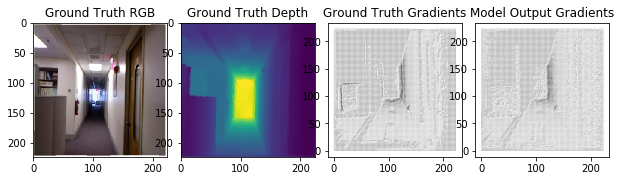

--- EPOCH 50/50 ---
test_batch (Avg. Loss 0.004: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 50
|rgb_minibatch|=torch.Size([1, 3, 224, 224])
|depth_minibatch|=torch.Size([1, 1, 224, 224])
|x_gt_minibatch|=torch.Size([1, 1, 224, 224])
|y_gt_minibatch|=torch.Size([1, 1, 224, 224])
|x_minibatch|=torch.Size([1, 1, 224, 224])
|y_minibatch|=torch.Size([1, 1, 224, 224])


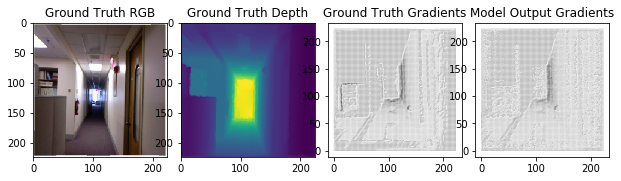

In [13]:
fit_res = trainer.fit(dl_train=dl_train, dl_test=dl_test, print_every=10, post_epoch_fn=post_epoch_plot, 
                      checkpoints=checkpoint_file)

In [14]:
fit_res.train_loss

[[0.07659581303596497],
 [0.06842625141143799],
 [0.05474548786878586],
 [0.03815501928329468],
 [0.023619720712304115],
 [0.013881254941225052],
 [0.009515960700809956],
 [0.00994929950684309],
 [0.013116010464727879],
 [0.016670478507876396],
 [0.019521072506904602],
 [0.01985475793480873],
 [0.01675773598253727],
 [0.015034624375402927],
 [0.013381347060203552],
 [0.011893345043063164],
 [0.011373884975910187],
 [0.010556556284427643],
 [0.010368640534579754],
 [0.009858761914074421],
 [0.00931578129529953],
 [0.009037372656166553],
 [0.008644232526421547],
 [0.00829984713345766],
 [0.008067110553383827],
 [0.007801386062055826],
 [0.007568595930933952],
 [0.00739336060360074],
 [0.007168336771428585],
 [0.0069797709584236145],
 [0.006842206232249737],
 [0.006688872817903757],
 [0.006513122469186783],
 [0.006355643272399902],
 [0.006215576082468033],
 [0.006099517457187176],
 [0.005978490225970745],
 [0.005844026803970337],
 [0.005726125556975603],
 [0.0056168739683926105],
 [0.0055

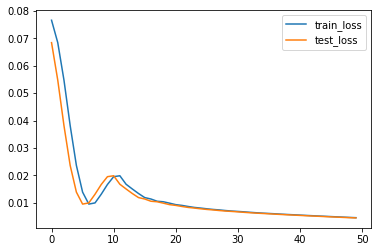

In [15]:
fig,ax = plt.subplots()
ax.plot(fit_res.train_loss, label='train_loss')
ax.plot(fit_res.test_loss, label='test_loss')
plt.legend()
plt.show()